In [1]:
#apply to 2D example
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
import pandas as pd

In [117]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_dist):
        super().__init__()
        self.act = nn.GELU()#lambda x: x * torch.sigmoid(x)
        self.marginal_prob_dist = marginal_prob_dist
        self.hidden_units = 64
        # inputs of data (x,y), timestep t
        self.mlp = nn.Sequential(
            nn.Linear(3, self.hidden_units, bias=True),
            nn.GELU(),
            nn.Linear(self.hidden_units, self.hidden_units, bias=True),
            nn.GELU(),
            nn.Linear(self.hidden_units, self.hidden_units, bias=True),
            nn.GELU(),
            nn.Linear(self.hidden_units, 2, bias=True)
        )
        
    def forward(self, x):
        t = x[:, 2]
        x = self.mlp(x)
        mean_coeff, sd = self.marginal_prob_dist(t)
        x = x / sd[:, None]
        return x

In [118]:
def marginal_prob_dist(t, beta_min, beta_max):
    t_squared = torch.pow(t, 2)
    mean_coeff = torch.exp(-1/4 * t_squared * (beta_max - beta_min) - 1/2 * t * beta_min)
    sd = torch.pow(1 - torch.exp(-1/2 * t_squared * (beta_max - beta_min) - t * beta_min), 2)
    return mean_coeff, sd

def beta_t(beta_min, beta_max, t):
    return beta_min + t*(beta_max - beta_min)

beta_min = 0.1
beta_max = 20

marginal_prob_dist_fn = functools.partial(marginal_prob_dist, beta_min=beta_min, beta_max=beta_max)
beta_t_fn = functools.partial(beta_t, beta_min=beta_min, beta_max=beta_max)

In [119]:
def loss_fn(model, x, marginal_prob_dist_fn, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the mean and standard deviation of the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device='cpu') * (1. - eps) + eps  
    mean_coeff, std = marginal_prob_dist_fn(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x * mean_coeff[:, None] + z * std[:, None]
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [149]:
y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
x = np.tanh(y) + z
ex_1 = torch.vstack([x, y]).T

y = -6 * torch.rand(100000) + 3
z = np.random.normal(0,np.sqrt(0.05), size = 100000)
x = torch.tanh(y+z)
ex_2 = torch.vstack([x, y]).T

y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
z = torch.tensor(z)
x = z*torch.tanh(y)
ex_3 = torch.vstack([x, y]).T

In [123]:
epochs = 200
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_dist_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ex_1.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/200 [00:00<?, ?it/s]

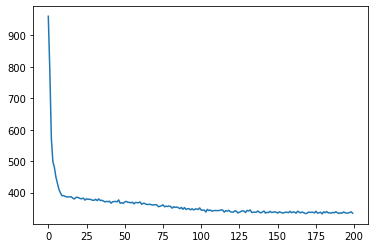

In [124]:
plt.plot(losses)

In [125]:
marginal_prob_dist_fn(torch.tensor(1))

(tensor(0.0066), tensor(0.9999))

In [144]:
num_steps =  1000
signal_to_noise_ratio = 0.16
def pc_sampler(score_model, marginal_prob_dist, beta_t, 
               batch_size=10000, num_steps=num_steps, eps=1e-1, snr = signal_to_noise_ratio):
    
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    xs = [x]
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)  
            
            
            score = score_model(x_with_t)
            mean_x = x + (1/2 * beta_t(t=batch_time_step)[:,None] + beta_t(t=batch_time_step)[:,None] * score) * step_size
            x = mean_x + torch.sqrt(step_size) * torch.sqrt(beta_t(t=batch_time_step)[:,None]) * torch.randn_like(x)  
            xs.append(x)
    # Do not include any noise in the last sampling step.
    return mean_x, xs

In [147]:
def density_plot(sample):
    df = pd.DataFrame(sample.numpy())
    df.columns =['x1', 'x2']
    sns.displot(df, x ='x1', y='x2', kind="kde")

In [145]:
pc_samples, xs= pc_sampler(score_model, 
                  marginal_prob_dist_fn,
                  beta_t_fn)

  0%|          | 0/1000 [00:00<?, ?it/s]

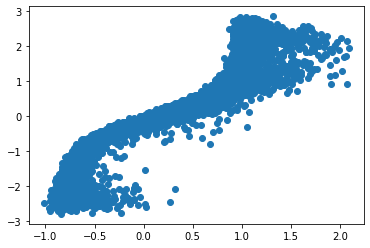

In [146]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

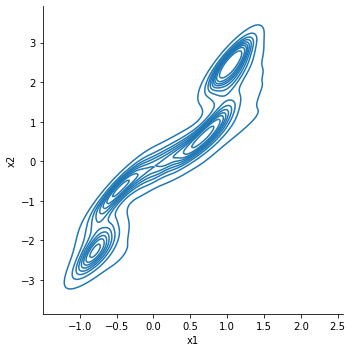

In [148]:
density_plot(pc_samples)

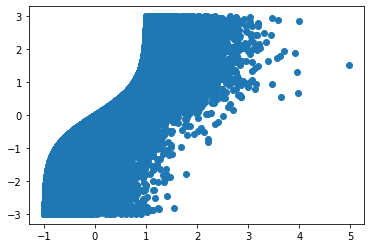

In [106]:
plt.scatter(ex_1[:,0], ex_1[:,1])

In [147]:
def density_plot(sample):
    df = pd.DataFrame(sample.numpy())
    df.columns =['x1', 'x2']
    sns.displot(df, x ='x1', y='x2', kind="kde")

In [150]:
epochs = 200
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_dist_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ddpm_ex_2.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/200 [00:00<?, ?it/s]

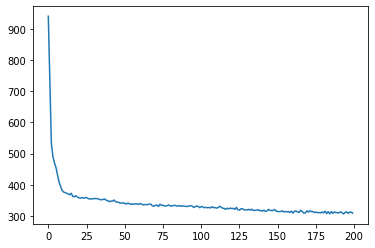

In [151]:
plt.plot(losses)

In [153]:
ckpt = torch.load('models/ddpm_ex_2.pth')
score_model.load_state_dict(ckpt)
pc_samples_2, xs= pc_sampler(score_model, 
                  marginal_prob_dist_fn,
                  beta_t_fn)

  0%|          | 0/1000 [00:00<?, ?it/s]

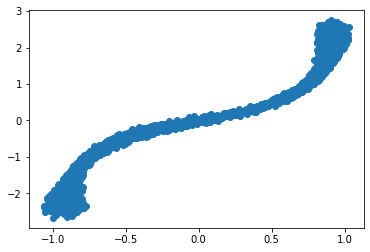

In [154]:
plt.scatter(pc_samples_2[:,0], pc_samples_2[:,1])

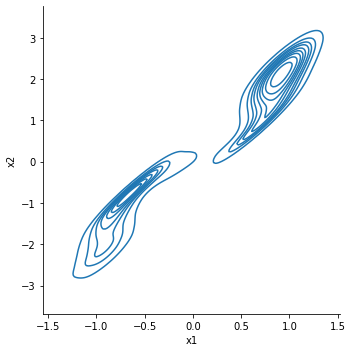

In [155]:
density_plot(pc_samples_2)

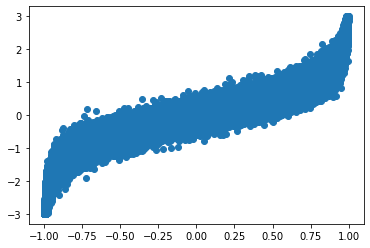

In [156]:
plt.scatter(ex_2[:,0], ex_2[:,1])

In [157]:
epochs = 200
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_3
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_dist_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ddpm_ex_3.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/200 [00:00<?, ?it/s]

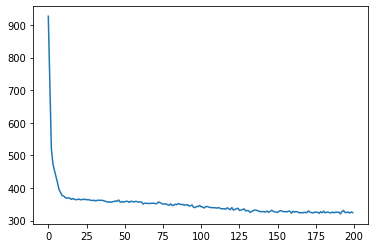

In [158]:
plt.plot(losses)

In [159]:
ckpt = torch.load('models/ddpm_ex_3.pth')
score_model.load_state_dict(ckpt)
pc_samples_3, xs= pc_sampler(score_model, 
                  marginal_prob_dist_fn,
                  beta_t_fn)

  0%|          | 0/1000 [00:00<?, ?it/s]

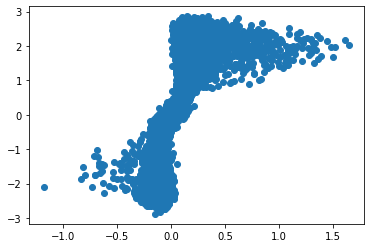

In [160]:
plt.scatter(pc_samples_3[:,0], pc_samples_3[:,1])

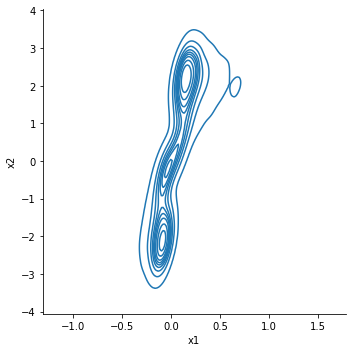

In [161]:
density_plot(pc_samples_3)

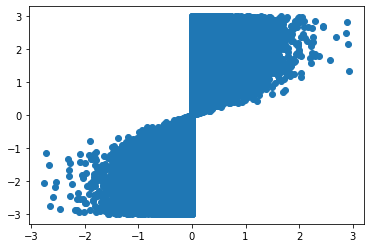

In [162]:
plt.scatter(ex_3[:,0], ex_3[:,1])

In [191]:
actual_samples_pos = np.random.gamma(1,0.3, size = 100000) + np.tanh(1.2)
actual_samples_0 = np.random.gamma(1,0.3, size = 100000) + np.tanh(0)
actual_samples_neg = np.random.gamma(1,0.3, size = 100000) + np.tanh(-1.2)

In [185]:
def get_diffused_y(y_obs, timesteps):
    timesteps = torch.flip(timesteps, [0])
    mean_coeff, sd = marginal_prob_dist_fn(timesteps)
    mean_coeff  = mean_coeff[:,None]
    sd = sd[:,None]
    diffused_y = y_obs*mean_coeff + torch.randn(timesteps.shape[0], 1) * sd
    return diffused_y

In [189]:
signal_to_noise_ratio = 0.16
num_steps =  1000

def CDiffE_pc_sampler(score_model, 
               marginal_prob_dist,
               beta_t,
               y_obs,
               batch_size=1000, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,
               eps=1e-1):

    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    diffused_y = [i.repeat(batch_size).reshape(batch_size,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            score = score_model(x_with_t)
            mean_x = x + (1/2 * beta_t(t=batch_time_step)[:,None] + beta_t(t=batch_time_step)[:,None] * score) * step_size
            x = mean_x + torch.sqrt(step_size) * torch.sqrt(beta_t(t=batch_time_step)[:,None]) * torch.randn_like(x)  
            
    # The last step does not include any noise
    return mean_x

In [193]:
ckpt = torch.load('ex_1.pth', map_location=device)
score_model.load_state_dict(ckpt)
cdiffe_samples_0 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 10000)
cdiffe_samples_neg = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 10000)
cdiffe_samples_pos = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 10000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

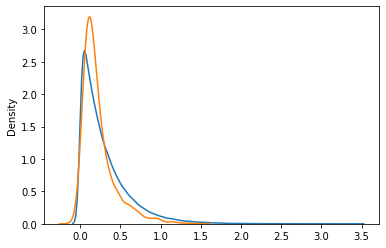

In [194]:
sns.kdeplot(actual_samples_0)
sns.kdeplot(cdiffe_samples_0[:,0])

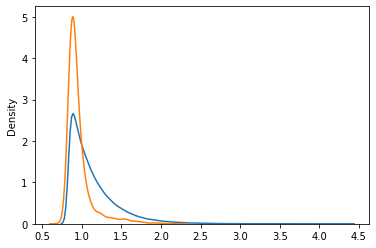

In [195]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(cdiffe_samples_pos[:,0])

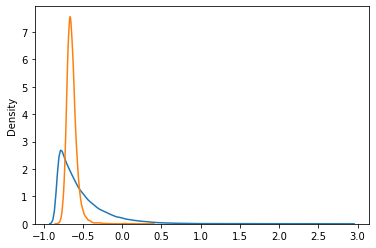

In [196]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(cdiffe_samples_neg[:,0])

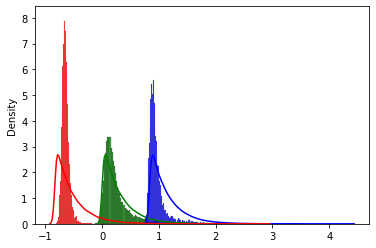

In [197]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cdiffe_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cdiffe_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cdiffe_samples_neg[:,0], stat = 'density', color = 'red')